# Quantum Nearest Neighbour: Quantum Implementation of K-Nearest Neighbor

This is a code implementation of distance-based classifier (similar to k-nearest neighbour algorithm) using quantum computer adapted from research paper ["Implementing a distance-based classifier with a quantum interference circuit"](https://arxiv.org/abs/1703.10793) by Maria Schuld, Mark Fingerhuth, and Francesco Petruccione. In this code I would not explain too many things to keep it clear and concise, please read the research paper if you would like to know the details (spoiler: the paper is so well written and easy to understand for anyone having some basics in quantum computation imo).

I found the modern Qiskit rewrite of the original code from the author [here](https://github.com/markf94/ibmq_code_epl_119_60002/blob/master/qiskit_distance_based_classifier.py). From my understanding, that code implementation is built specifically based on the datapoints used in the paper. So I decided to create a new one (this code) that can be implemented using any datapoints from the Iris dataset.

Goal of this code: <br>
Take any three datapoints from the datasets and use two of them as training input, then we would like to predict the label/class of the third one using the quantum version of distance-based classifier.

## Data Preprocessing

We will only use the first 2 classes, 'setosa' (0) and 'versicolor' (1), and the first 2 features, 'sepal length' and 'sepal width'.

We need to do 3 things before we go to the quantum side: <br>
1. [Standardization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): make the datasets having zero mean and unit variance. <br>
2. [Normalization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html): normalize the features value for every datapoints. <br>
3. Angle extraction: After 1). and 2)., every datapoints can be represented as a coordinate vector inside a unitary circle (circle coordinate) with the origin as its center. We can extract the value of the angle form by the vector and the positive x-axis, and then replace the datapoint with this value. We need to do this because we will use [Quantum Amplitude Embedding](https://pennylane.ai/qml/glossary/quantum_embedding.html) scheme to convert the datasets into quantum states.

In [1]:
# import relevant libraries

import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import normalize, StandardScaler

In [77]:
# load the datasets

iris = datasets.load_iris()

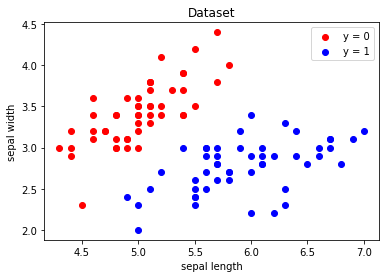

In [78]:
# take only the first 2 classes and the first 2 features

y = iris.target
X = np.concatenate((iris.data[:, :2][np.where(y == 0)], iris.data[:, :2][np.where(y == 1)]))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.scatter(X[np.where(y == 0)][:,0], X[np.where(y == 0)][:,1], color='red', label='y = 0')
plt.scatter(X[np.where(y == 1)][:,0], X[np.where(y == 1)][:,1], color='blue', label='y = 1')

plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.title('Dataset')

plt.legend()
plt.show()

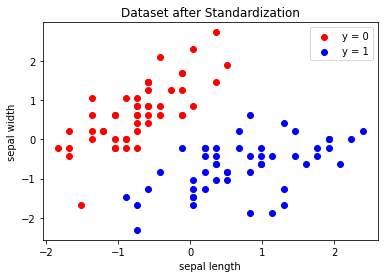

In [79]:
# standardization

X = StandardScaler().fit_transform(X)

plt.scatter(X[np.where(y == 0)][:,0], X[np.where(y == 0)][:,1], color='red', label='y = 0')
plt.scatter(X[np.where(y == 1)][:,0], X[np.where(y == 1)][:,1], color='blue', label='y = 1')

plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.title('Dataset after Standardization')

plt.legend()
plt.show()

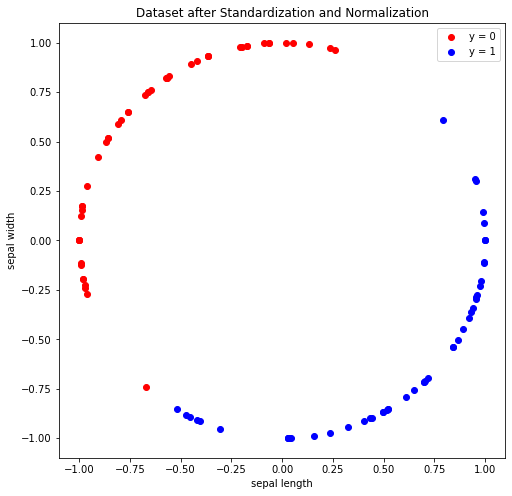

In [84]:
# normalization

X = normalize(X)

#X_train_0 = X[12, :]
#X_train_1 = X[84, :]

#X_test_0 = X[28, :]
#X_test_1 = X[36, :]
#X_test_2 = X[80, :]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.scatter(X[np.where(y == 0)][:,0], X[np.where(y == 0)][:,1], color='red', label='y = 0')
plt.scatter(X[np.where(y == 1)][:,0], X[np.where(y == 1)][:,1], color='blue', label='y = 1')

#plt.scatter(X_train_0[0], X_train_0[1], color='black', label='train data')
#plt.scatter(X_train_1[0], X_train_1[1], color='black')

#plt.scatter(X_test_0[0], X_test_0[1], color='yellow', label='test data')
#plt.scatter(X_test_1[0], X_test_1[1], color='yellow')
#plt.scatter(X_test_2[0], X_test_2[1], color='yellow')

plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.title('Dataset after Standardization and Normalization')

plt.legend()
plt.show()

For any coordinate vector of a datapoint after standardization and normalization

$$
x = \left[\begin{array}{c}
a \\
b
\end{array}\right]
$$

we can represent that datapoint in circle coordinate (r, θ)

$$
x = \left[\begin{array}{c}
r = 1 \\
θ
\end{array}\right]
$$

where $a$ is the sepal length feature's value and $b$ is the sepal width feature's value. The value of $r$ here is $1$ for all datapoints because of standardization and normalization, hence we can drop the $r$ and represent all datapoints with their respective angle

$$
x^m = θ^m
$$

$m$ denotes the index of the sample in the dataset.

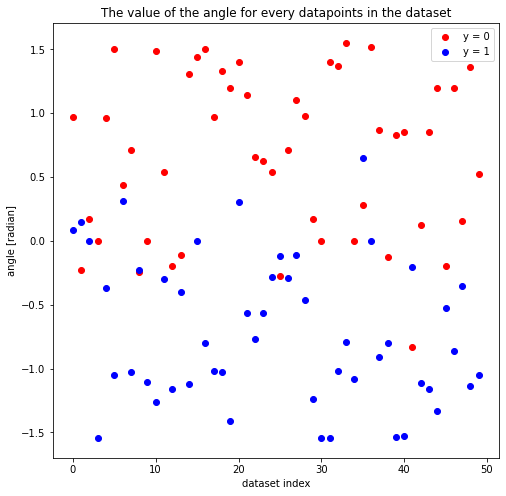

In [83]:
# features to angles: change the coordinate vector of a datapoint from cartesian to circle coordinate

X_angle = np.arcsin(X[:,1])

plt.scatter(np.linspace(0, 49, 50), X_angle[np.where(y == 0)], color='red', label='y = 0')
plt.scatter(np.linspace(0, 49, 50), X_angle[np.where(y == 1)], color='blue', label='y = 1')

plt.xlabel('dataset index')
plt.ylabel('angle [radian]')
plt.title('The value of the angle for every datapoints in the dataset')

plt.legend()
plt.show()

## Building the Quantum Circuit

In this part, we would like to build a quantum circuit for quantum amplitude embedding and classification. We need 4 qubits for the circuit and 2 classical bits for measurements. I asigned the qubits as below:

qubit 0: the index qubit, it is for flagging the $\textit{m}th$ training input. <br>
qubit 1: the ancilla qubit, it acts as a differentiator between training and testing input. <br>
qubit 2: the input qubit, it acts as a register for the training and testing input. <br>
qubit 3: the class qubit, it encodes the class information (either 0 or 1).

To encode the datapoints into quantum states, we will use $RY(θ)$ gate to rotate the qubit around the Y-axis

In [7]:
# import relevant libraries

from qiskit import *
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import noise
provider = IBMQ.load_account()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


To do the amplitude embedding, we need a CCRY gate. A CCRY(θ) gate can be decompose as below:
<img src="./CCRY decomposition.png">

In [67]:
# decomposition function for CCRY gate

def CCRY(control, target, theta, num_qubit):
    qc = QuantumCircuit(num_qubit)
    
    qc.ccx(control[0], control[1], target)
    qc.cx(control[0], target)
    qc.ry(theta/4, target)
    qc.cx(control[0], target)
    qc.ry(-1*theta/4, target)
    qc.ccx(control[0], control[1], target)
    qc.cx(control[0], target)
    qc.ry(-1*theta/4, target)
    qc.cx(control[0], target)
    qc.ry(theta/4, target)
    
    return qc

In [24]:
def state_prep(theta_0, theta_1, theta_test):
    qc = QuantumCircuit(4)
    qc.h(0)
    qc.h(1)
    qc.barrier()

    # prepare the state for the testing data (x_test)
    qc.cry(theta_test, 1, 2)
    qc.barrier()

    # prepare the state for the label (y^m)
    qc.cx(0, 3)
    qc.barrier()

    # prepare the state for the first training data (x_0)
    qc.x(0)
    qc.x(1)
    qc = qc + CCRY([0,1], 2, theta_0, 4)
    qc.barrier()

    # prepare the state for the second training data (x_1)
    qc.x(0)
    qc = qc + CCRY([0,1], 2, theta_1, 4)
    qc.barrier()

    # flip back the ancilla qubit
    qc.x(1)
    qc.barrier()
    
    return qc

In [25]:
def quantum_nearest_neighbour(theta_0, theta_1, theta_test):
    qc = QuantumCircuit(4, 2)
    
    # state preparation
    qc += state_prep(theta_0, theta_1, theta_test)
    
    # apply the Hadamard gate to the ancilla qubit
    qc.h(1)
    
    # apply measurement to the ancilla qubit and label qubit (y^m)
    qc.measure([1, 3], [0, 1])
    
    return qc

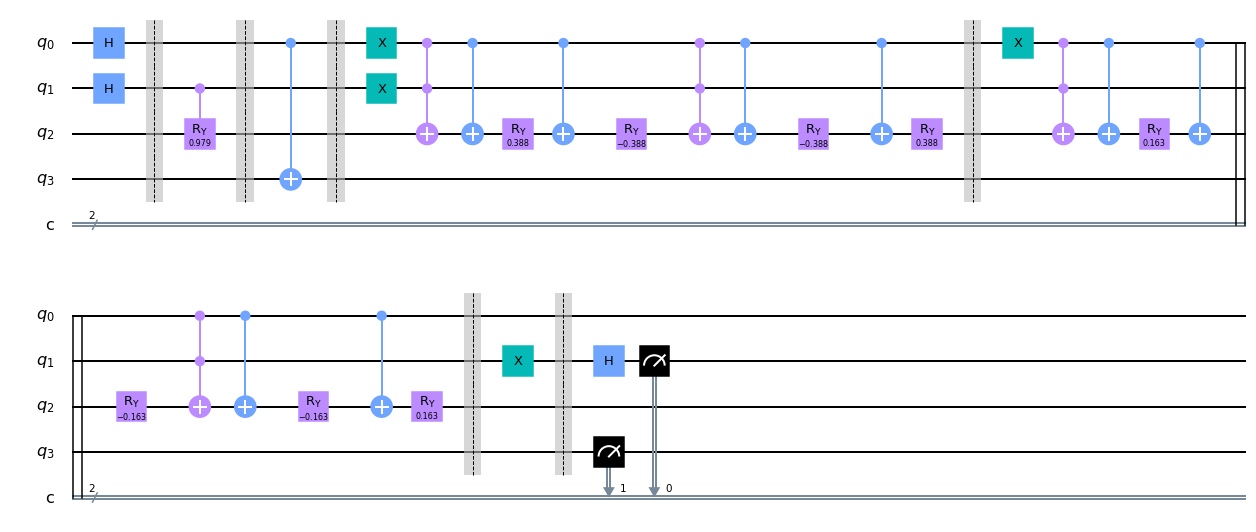

In [26]:
theta_0 = X_angle[33]
theta_1 = X_angle[85]

theta_test = X_angle[28]

quantum_nearest_neighbour(theta_0, theta_1, theta_test).draw('mpl')

In [52]:
#Define the noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
noise_model = noise.NoiseModel.from_backend(device)

simulator = Aer.get_backend('qasm_simulator')

# we can also run the circuit without noise by giving 0 to the noise_model argument
def run(mycircuit, iteration, simulator=simulator, noise_model=noise_model):
    if noise_model == 0:
        counts = execute(mycircuit, simulator, shots=iteration).result().get_counts(mycircuit)
    else:
        counts = execute(mycircuit, simulator, shots=iteration, noise_model=noise_model).result().get_counts(mycircuit)
    return counts

In [23]:
def hardlim(x):
    if x >= 0.5:
        return 0
    else:
        return 1

In [55]:
train_id = [12, 84]

theta_0 = X_angle[train_id[0]]
theta_1 = X_angle[train_id[1]]

shots = 10000

y_pred = []

acc  = 0

for i in range (len(X_angle)):
    if i != train_id[0] and i != train_id[1]:
        theta_test = X_angle[i]
        result = run(quantum_nearest_neighbour(theta_0, theta_1, theta_test), shots, noise_model=0)
        y_pred.append(hardlim((result['00']/1000)/(result['00']/1000 + result['10']/1000)))
        if y_pred[-1] == y[i]:
            acc += 1

acc = acc/(len(X_angle)-2)

print("Test accuracy:", acc)

Test accuracy: 0.7857142857142857
